# **Ch03-c. Convolutional Network, AlexNet**

##### Config

In [13]:
import math, re, os, sys
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.19.0


---
### **Convolutional Neural Network (卷積神經網路)**
* 專為影像設計, 透過在影像上滑動 `卷積過濾器(convolutional filter)` 的小視窗來運作
* 典型的 filter 是 3×3×3 或 5×5×3 的大小 (RGB三個channel都有各自的參數)
* filter 會將該位置的`像素值乘以 filter 上的 weights` 並`相加`, 得到`點積(dot product)`; 透過滑動 filter 來計算每個位置的點積, 此過程就是`卷積(convolution)`！
* 每一個卷積層通常包含數十或數百個 filter, 每個 filter 都有自己的 weights 可以訓練, 而`每一個 filter 得到的結果都會變成輸出的其中一個 channel` (也就是如果有64個filter, 輸出會是[x, y, 64])
* 經過 `conv 或是 pool 的輸出, 就稱作 feature map`

In [3]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

!gsutil cat gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv | head -10

gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/sunflowers/14646281372_5f13794b47.jpg,sunflowers
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/sunflowers/1022552002_2b93faf9e7_n.jpg,sunflowers
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/sunflowers/50987813_7484bfbcdf.jpg,sunflowers
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/sunflowers/21995435890_e5672244a4_m.jpg,sunflowers
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/14124669683_7fb74f20c3.jpg,tulips
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/7133935763_82b17c8e1b_n.jpg,daisy
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/9489270024_1b05f08492_m.jpg,daisy
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/3611577717_f3a7a8c416_n.jpg,daisy
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/roses/4504731519_9a260b6607_n.jpg,roses
gs://practical-ml-vision-bo

\*PS: 因為 tensorflow-addons 已經不再支援, 所以下面的程式有自己進行改寫, 不過原理皆相同

(-0.5, 223.5, 223.5, -0.5)

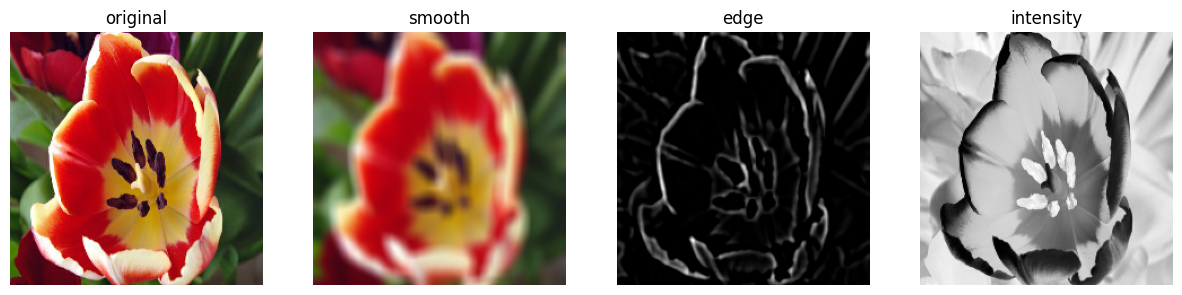

In [4]:
img = read_and_decode('gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/14124669683_7fb74f20c3.jpg')

f, ax = plt.subplots(1, 4, figsize=(15,5))

ax[0].imshow(img.numpy())
ax[0].set_title('original')
ax[0].axis('off')


# 平滑圖(mean): 由 average pooling 達成
# mean = tfa.image.mean_filter2d(img, filter_shape=11)
def mean_filter(img, ksize):
    img = tf.cast(img, tf.float32)
    img = tf.expand_dims(img, axis=0)  # 加上 batch 維度 (因為下面的 pooling layer 要用)
    img = tf.nn.avg_pool2d(img, ksize=ksize, strides=1, padding='SAME')
    return tf.squeeze(img, axis=0)  # 移除 batch 維度
mean = mean_filter(img, ksize=11)
ax[1].imshow(mean.numpy())
ax[1].set_title('smooth')
ax[1].axis('off')

# 邊緣圖(edge): 用模糊程度差異估邊緣
# edge = tf.clip_by_value(tf.image.rgb_to_grayscale(
#     tfa.image.mean_filter2d(img, filter_shape=5) - tfa.image.mean_filter2d(img, filter_shape=11)
# ), 0, 1)
blur_small = mean_filter(img, ksize=5)
blur_large = mean_filter(img, ksize=11)
edge = tf.clip_by_value(tf.image.rgb_to_grayscale(blur_small - blur_large), 0.0, 1.0)
ax[2].imshow(edge.numpy(), cmap='gray')
ax[2].set_title('edge')
ax[2].axis('off')

# 反轉強度圖(intensity): 1 - 原先值
bw_img = 1.0 - tf.image.rgb_to_grayscale(img)
ax[3].imshow(bw_img.numpy(), cmap='gray')
ax[3].set_title('intensity')
ax[3].axis('off')

### Strides & Padding
* **`Strides`**: Filter 每一步滑動的大小, default 為 1, 調大會讓輸出的 dimension 變小
* **`Padding`**: padding='valid' 代表不做padding, 所以輸出dimension會變小; padding='same' 代表做 zero-padding, 讓輸出跟 input 保持一樣的 dimension

### Pooling Layer (池化層)
* 卷積層的 filter 數量會決定 output 的 channel 數, 那麼`每個 channel 的 dimension` 由誰來控制呢？
* 因為我們的目標是萃取重要資訊, 所以 dimension 勢必要變小的, 所以要經過 `downsample 的 layer`！
* 常見的 pooling 有 `n×n max pooling (僅保留n×n中最大的一個值)` 和 `n×n average pooling (n×n中所有像素的平均值)`, 一樣由 pool_size 與 strides 兩者來控制

---
## **AlexNet**
* Alexnet 是 classification 領域最早的成功案例之一, 他的結構如下圖：
* 每個卷積層的 activation function 都是選用 ReLU
* 經過 pool5 之後, 會先 Flatten(), 再經過三個 fully-connected network, 最後經由 softmax 做出預測！
 
![alt text](Images/AlexNet.jpg "AlexNet_structure")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
REPLICAS:  1
Learning rate schedule: 0.0001 to 0.0001 to 1.62e-05


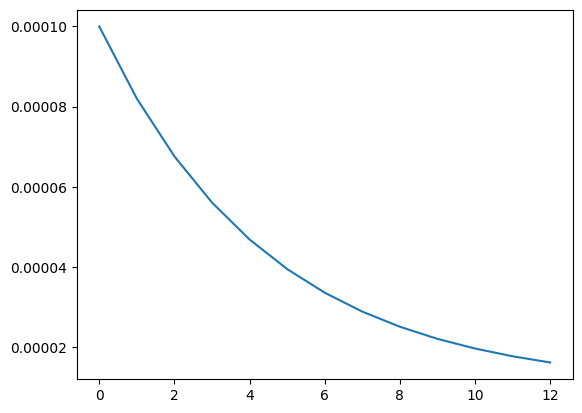

In [10]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

GCS_DS_PATH = "gs://practical-ml-vision-book-data/flowers_104_tfr"

# Settings for TPUv3. When running on hardware with less memory such as a TPUv2 (Colab)
# or a GPU, you might have to use lower BATCH_SIZE and/or IMAGE_SIZE values.

IMAGE_SIZE = [224, 224] # available image sizes in flowers104 dataset: 512x512, 331x331, 224x224, 192,192
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 13

# Learning rate schedule
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

# This dataset is split three ways, training, validation, test
# but we will use it split two ways only: training and validation.
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
VALIDATION_FILENAMES =  tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [11]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X autoscales y axis for the last X% of data points
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation,'--')
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

### Dataset

In [14]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) # decoded inamge in uint8 format range [0,255]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    idnum = example['id'] # image id, not used
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 16465 training images, 7382 validation images


In [15]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
Training data label examples: [ 72   1  66 ...  48 102  56]


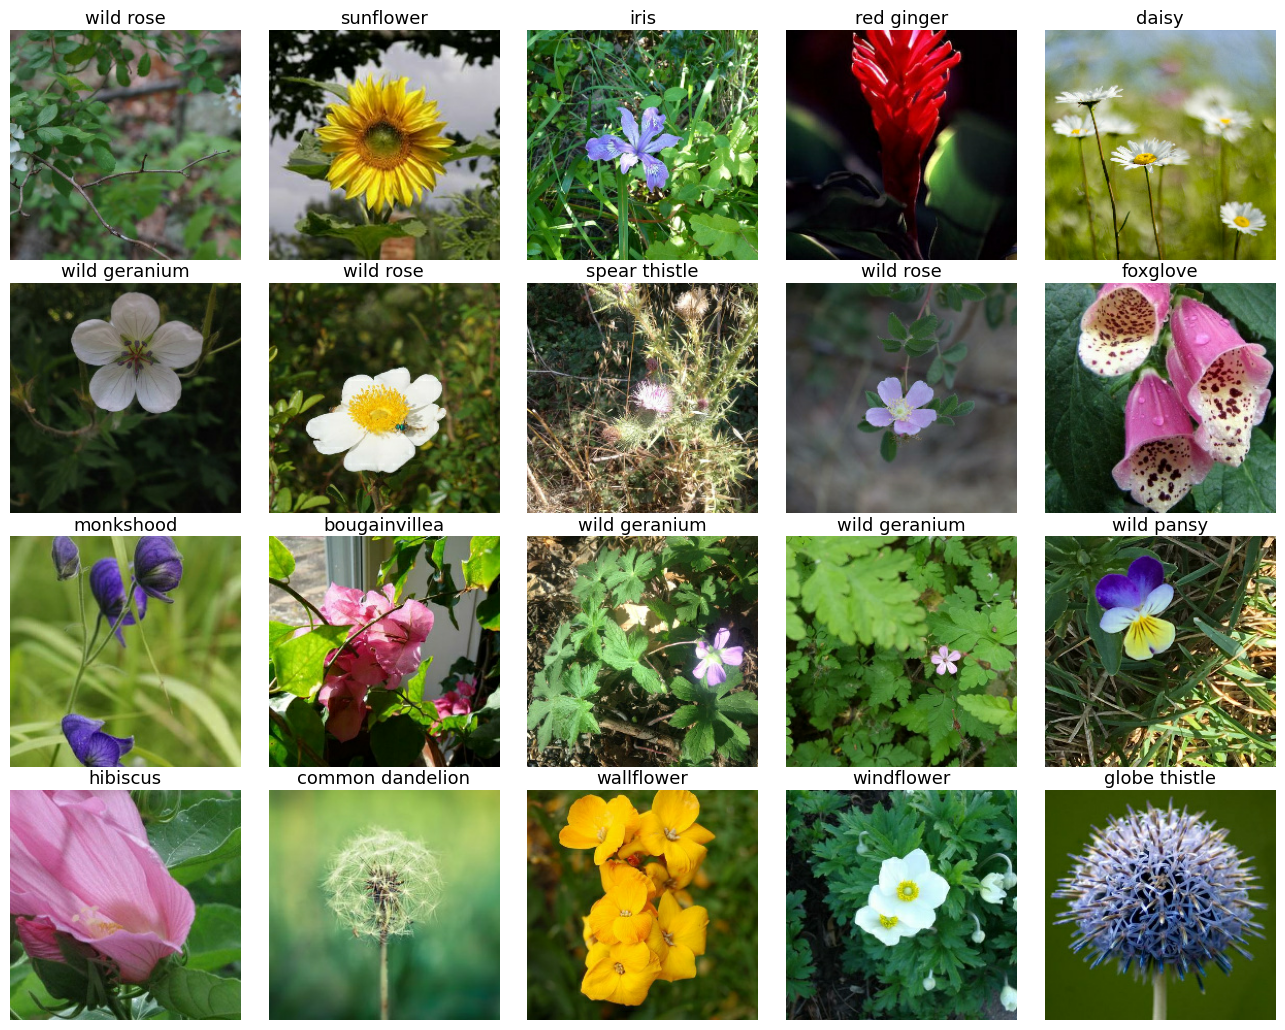

In [16]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

### **Model**

In [19]:
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=[*IMAGE_SIZE, 3]),
        # It would be best practice to convert the image from int [0,255] to float [-1,1]
        # format here but this model converges just as well without it.
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
        steps_per_execution=8
    )
    model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 50, 50, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 23, 23, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 11, 11, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 9, 9, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 7, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 104)            │       426,088 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,395,880 (115.95 MB)

 Trainable params: 30,395,880 (115.95 MB)

 Non-trainable params: 0 (0.00 B)

### **Training**
需要 GPU or TPU, 所以...先不跑囉XD

In [ ]:
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])

In [ ]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211, zoom_pcent=90)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

---
### AlexNet 優缺點

##### **缺點**:
* 第一層選擇使用 11×11 的 filter, 對訓練來說是非常代價高昂的, 且後來發現 使用更小的 3×3 filter 能有更好的效果
* 最後3層 fully-connected layer 加起來有超過2600萬個weight要學！前面的conv加起來也才370萬左右而已
* 模型太淺了, 只有8層, 現代的網路常常多於一百層

##### **優點**:
* 第一層 11×11 的 filter 可以視覺化成為 11×11×3 的圖片, 從中我們會發現它學會了偵測各種直線、各種紋理、顏色, 而這些特徵在後續的卷積層上可以被組合成各種物件！
* 例如: 神經網路可以將這一層得到的紋理與線條組合成「車輪」「坐墊」「龍頭」等形狀, 然後再將它們組合成「機車」